In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import datetime

import IPython
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings(action='ignore')

import lightgbm as lgb
from tqdm import tqdm 
import time

In [2]:
path = "/content/drive/MyDrive/Colab Notebooks/cw_dacon/gas/"

In [5]:
data = pd.read_csv(path+'20181231.csv', encoding='cp949')

In [ ]:
pd.isnull(data).sum()

연월일    0
시간     0
구분     0
공급량    0
기온     0
dtype: int64

In [ ]:
data['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [6]:
data['연월일'] = pd.to_datetime(data['연월일'])
data['year'] = data['연월일'].dt.year
data['month'] = data['연월일'].dt.month
data['day'] = data['연월일'].dt.day
data['weekday'] = data['연월일'].dt.weekday

In [7]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')
data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']

In [8]:
#last_gas feature added
data['last_gas'] = data.groupby('구분')['공급량'].shift(8736)
#int to categorical type
data['구분'] = data['구분'].astype('category')
data

,연월일,시간,구분,공급량,year,month,day,weekday,월일시,last_gas
0,2013-01-01,1,A,2497.129,2013,1,1,1,01-01_1,NaN
1,2013-01-01,2,A,2363.265,2013,1,1,1,01-01_2,NaN
2,2013-01-01,3,A,2258.505,2013,1,1,1,01-01_3,NaN
3,2013-01-01,4,A,2243.969,2013,1,1,1,01-01_4,NaN
4,2013-01-01,5,A,2344.105,2013,1,1,1,01-01_5,NaN
...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,2018,12,31,0,12-31_20,556.857
368084,2018-12-31,21,H,669.961,2018,12,31,0,12-31_21,556.502
368085,2018-12-31,22,H,657.941,2018,12,31,0,12-31_22,545.146
368086,2018-12-31,23,H,610.953,2018,12,31,0,12-31_23,496.522


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   연월일       368088 non-null  object  
 1   시간        368088 non-null  object  
 2   구분        368088 non-null  category
 3   공급량       368088 non-null  float64 
 4   기온        368088 non-null  float64 
 5   year      368088 non-null  int64   
 6   month     368088 non-null  int64   
 7   day       368088 non-null  int64   
 8   weekday   368088 non-null  int64   
 9   월일시       368088 non-null  object  
 10  last_gas  306936 non-null  float64 
dtypes: category(1), float64(3), int64(4), object(3)
memory usage: 28.4+ MB


In [9]:
idx_list = []
sup_rolling_df = pd.DataFrame()

for idx in tqdm(data['구분'].unique()) :
    temp_df = data[data['구분']==idx]
    temp_df['5D_moving_avg'] = temp_df['공급량'].rolling(window=5).mean()
    temp_df['5D_moving_avg'] = temp_df['5D_moving_avg'].fillna(method='backfill')
    sup_rolling_df = sup_rolling_df.append(temp_df)

100%|██████████| 7/7 [00:00<00:00, 17.83it/s]


In [ ]:
sup_rolling_df[sup_rolling_df['구분'] == 'E']

,연월일,시간,구분,공급량,기온,year,month,day,weekday,월일시,last_gas,5D_moving_avg
35040,2013-01-01,1,E,3272.837,-8.8,2013,1,1,1,01-01_1,NaN,3047.2642
35041,2013-01-01,2,E,3057.125,-8.5,2013,1,1,1,01-01_2,NaN,3047.2642
35042,2013-01-01,3,E,2907.765,-8.5,2013,1,1,1,01-01_3,NaN,3047.2642
35043,2013-01-01,4,E,2930.789,-9.0,2013,1,1,1,01-01_4,NaN,3047.2642
35044,2013-01-01,5,E,3067.805,-9.1,2013,1,1,1,01-01_5,NaN,3047.2642
...,...,...,...,...,...,...,...,...,...,...,...,...
350563,2018-12-31,20,E,4074.485,-2.8,2018,12,31,0,12-31_20,3182.007,3625.2616
350564,2018-12-31,21,E,4037.720,-3.5,2018,12,31,0,12-31_21,3112.005,3799.5736
350565,2018-12-31,22,E,3954.210,-4.0,2018,12,31,0,12-31_22,3098.472,3928.8994
350566,2018-12-31,23,E,3745.844,-4.6,2018,12,31,0,12-31_23,2952.844,3958.3270


In [10]:
len(sup_rolling_df) == len(data)

True

In [11]:
sup_rolling_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
공급량,368088.0,948.100037,927.211578,1.378,221.973,637.014,1398.91900,11593.6170
year,368088.0,2015.500228,1.707471,2013.000,2014.000,2016.000,2017.00000,2018.0000
month,368088.0,6.523962,3.448424,1.000,4.000,7.000,10.00000,12.0000
day,368088.0,15.726609,8.798824,1.000,8.000,16.000,23.00000,31.0000
weekday,368088.0,3.000000,2.000003,0.000,1.000,3.000,5.00000,6.0000
last_gas,306936.0,935.239281,909.464117,1.378,218.992,629.359,1384.12025,11593.6170
5D_moving_avg,368088.0,948.083673,914.708994,1.378,232.929,635.731,1399.83630,6452.7474


In [12]:
df = pd.get_dummies(sup_rolling_df, columns = ['구분'])

In [13]:
features = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H','5D_moving_avg','공급량', '기온']
X = df[features]

KeyError: ignored

In [14]:
num = ['5D_moving_avg']
cat = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H', '기온']
X[cat] = X[cat].astype(str)

NameError: ignored

In [ ]:
train_years = ['2013','2014','2015','2016','2017']
val_years = ['2018']
train = X[X['year'].isin(train_years)]
val = X[X['year'].isin(val_years)]

In [ ]:
train

,시간,year,month,day,weekday,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H,5D_moving_avg,공급량,기온
0,1,2013,1,1,1,1,0,0,0,0,0,0,2341.3946,2497.129,-8.8
1,2,2013,1,1,1,1,0,0,0,0,0,0,2341.3946,2363.265,-8.5
2,3,2013,1,1,1,1,0,0,0,0,0,0,2341.3946,2258.505,-8.5
3,4,2013,1,1,1,1,0,0,0,0,0,0,2341.3946,2243.969,-9.0
4,5,2013,1,1,1,1,0,0,0,0,0,0,2341.3946,2344.105,-9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306763,20,2017,12,31,6,0,0,0,0,0,0,1,465.8186,517.264,0.1
306764,21,2017,12,31,6,0,0,0,0,0,0,1,492.7878,530.896,-0.6
306765,22,2017,12,31,6,0,0,0,0,0,0,1,510.1782,506.287,-1.0
306766,23,2017,12,31,6,0,0,0,0,0,0,1,509.1778,470.638,-1.1


In [ ]:
X_train = train.drop(['공급량'],axis=1)
y_train = train['공급량']

X_val = val.drop(['공급량'],axis=1)
y_val = val['공급량']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   

train_scaled = scaler.fit(X_train)

X_train_ = scaler.fit_transform(X_train)
X_val_ = scaler.fit_transform(X_val)

In [ ]:
print(X_train_.shape, len(y_train), X_val_.shape, len(y_val))

(306768, 14) 306768 (61320, 14) 61320


In [ ]:
# input reshape 3 dim
X_train_t = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_val_t = X_val_.reshape(X_val_.shape[0], X_val_.shape[1], 1)

print("최종 DATA")
print(X_train_t.shape, X_val_t.shape)
print(y_train)

최종 DATA
(306768, 14, 1) (61320, 14, 1)
0         2497.129
1         2363.265
2         2258.505
3         2243.969
4         2344.105
            ...   
306763     517.264
306764     530.896
306765     506.287
306766     470.638
306767     444.618
Name: 공급량, Length: 306768, dtype: float64


LSTM🐈

In [ ]:
K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(14, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCH = 100
BATCH_SIZE = 30

In [ ]:
from keras.callbacks import ModelCheckpoint

filename = 'LSTM_checkpoint-trial-002.h5'
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출됩니다
                             patience=5,
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto',           # auto는 알아서 best를 찾습니다. min/max
                             restore_best_weights = True
                            )

history = model.fit(X_train_t, y_train, 
      validation_data=(X_val_t,y_val),
      epochs=100, 
      batch_size=30,
          verbose=1,
      callbacks=[checkpoint] # checkpoint 콜백
     )

Epoch 1/100
10225/10226 [============================>.] - ETA: 0s - loss: 1506845.1250
Epoch 00001: val_loss improved from inf to 1657900.50000, saving model to LSTM_checkpoint-trial-002.h5
10226/10226 [==============================] - 69s 6ms/step - loss: 1506796.0000 - val_loss: 1657900.5000
Epoch 2/100
10222/10226 [============================>.] - ETA: 0s - loss: 1213041.5000
Epoch 00002: val_loss improved from 1657900.50000 to 1377201.37500, saving model to LSTM_checkpoint-trial-002.h5
10226/10226 [==============================] - 63s 6ms/step - loss: 1212989.7500 - val_loss: 1377201.3750
Epoch 3/100
10222/10226 [============================>.] - ETA: 0s - loss: 1007677.8750
Epoch 00003: val_loss improved from 1377201.37500 to 1184631.25000, saving model to LSTM_checkpoint-trial-002.h5
10226/10226 [==============================] - 63s 6ms/step - loss: 1007540.2500 - val_loss: 1184631.2500
Epoch 4/100
10220/10226 [============================>.] - ETA: 0s - loss: 826876.3125
Ep

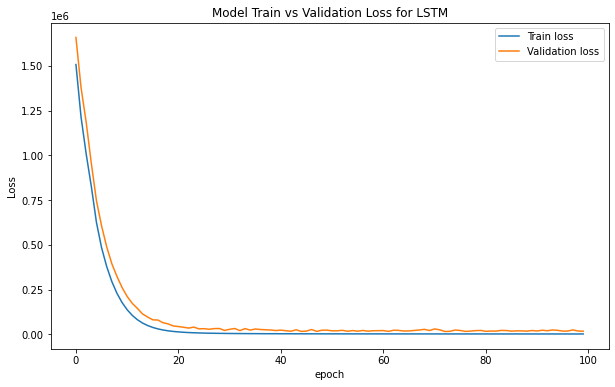

In [ ]:
# loss check
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history, 'LSTM')

In [ ]:
from tensorflow.python.keras.models import load_model
model_LSTM = load_model("LSTM_checkpoint-trial-002.h5")

In [ ]:
# validatation set prediction
y_pred_ = model.predict(X_val_t)

Text(0, 0.5, 'Predict: $\\hat{Y}_i$')

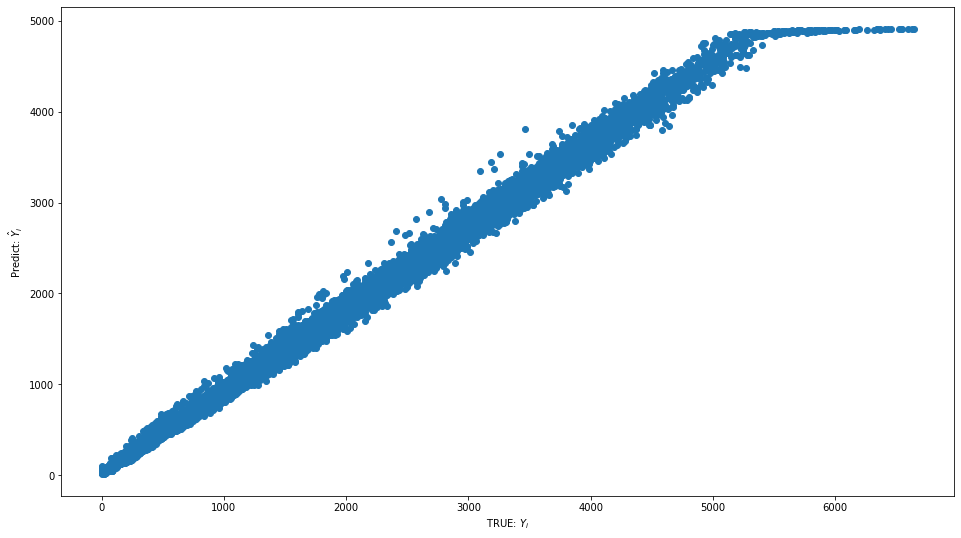

In [ ]:
plt.scatter(y_val, y_pred_)
plt.xlabel("TRUE: $Y_i$")
plt.ylabel("Predict: $\hat{Y}_i$")

**METRIC**

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred_)
rmse = mse**0.5
r_2 = r2_score(y_val, y_pred_)

print(mse)
print(rmse)
print(r_2)

18349.216885109683
135.45928128079552
0.9819993667525864


**TEST** **SET** **PREPROCESSING**

In [ ]:
# test => inference dataset
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
data['연월일'] = data['연월일'].astype('str')
data['시간'] = data['시간'].astype('str')

test['일자'] = test['일자'].astype('str')
test['시간'] = test['시간'].astype('str')

data['월일시'] = data['연월일'].str[5:] + '_' + data['시간']
test['월일시'] = test['일자'].str[5:] + '_' + test['시간']

In [ ]:
test

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5
...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23


In [ ]:
test['월일시'].unique()

array(['01-01_1', '01-01_2', '01-01_3', ..., '03-31_22', '03-31_23',
       '03-31_24'], dtype=object)

In [ ]:
date = []
supplier = []
mv_avg = []
for i in tqdm(test['월일시'].unique()) :
    df_mv_avg = sup_rolling_df[sup_rolling_df['월일시']==i]
    
    for j in df_mv_avg['구분'].unique() :
        supplier_mean_df = df_mv_avg[df_mv_avg['구분']==j]
        mean_list = round(np.mean(supplier_mean_df['5D_moving_avg']),4)
     
        date.append(supplier_mean_df['월일시'].iloc[0])
        supplier.append(supplier_mean_df['구분'].iloc[0])
        mv_avg.append(mean_list)

100%|██████████| 2160/2160 [01:05<00:00, 33.12it/s]


In [ ]:
temp_df

,연월일,시간,구분,공급량,기온,year,month,day,weekday,월일시,last_gas,5D_moving_avg
52560,2013-01-01,1,H,562.964,-8.8,2013,1,1,1,01-01_1,NaN,523.0568
52561,2013-01-01,2,H,531.228,-8.5,2013,1,1,1,01-01_2,NaN,523.0568
52562,2013-01-01,3,H,496.276,-8.5,2013,1,1,1,01-01_3,NaN,523.0568
52563,2013-01-01,4,H,489.396,-9.0,2013,1,1,1,01-01_4,NaN,523.0568
52564,2013-01-01,5,H,535.420,-9.1,2013,1,1,1,01-01_5,NaN,523.0568
...,...,...,...,...,...,...,...,...,...,...,...,...
368083,2018-12-31,20,H,681.033,-2.8,2018,12,31,0,12-31_20,556.857,604.7030
368084,2018-12-31,21,H,669.961,-3.5,2018,12,31,0,12-31_21,556.502,635.0934
368085,2018-12-31,22,H,657.941,-4.0,2018,12,31,0,12-31_22,545.146,658.2096
368086,2018-12-31,23,H,610.953,-4.6,2018,12,31,0,12-31_23,496.522,659.7726


In [ ]:
temp_df = pd.DataFrame()

In [ ]:
temp_df['월일시'] = date
temp_df['구분'] = supplier
temp_df['5D_moving_avg'] = mv_avg

In [ ]:
temp_df[temp_df['월일시'] == '01-01_4']

,월일시,구분,5D_moving_avg
21,01-01_4,A,1825.0762
22,01-01_4,B,1637.6443
23,01-01_4,C,190.3049
24,01-01_4,D,1110.6390
25,01-01_4,E,2406.0732
26,01-01_4,G,2743.7452
27,01-01_4,H,422.1951


In [ ]:
# 월일시, 구분, 평균 이 필요
print(supplier_mean_df['월일시'].iloc[0],
supplier_mean_df['구분'].iloc[0],
round(np.mean(supplier_mean_df['5D_moving_avg']),4))

03-31_24 H 298.3528


In [ ]:
test_set = pd.merge(test, temp_df, on = ['구분','월일시'], how = 'left')

In [ ]:
test_set

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시,5D_moving_avg
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1,2095.5065
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2,2002.3103
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3,1907.0166
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4,1825.0762
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5,1779.5306
...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20,239.8929
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21,268.8691
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22,291.2746
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23,302.2607


In [ ]:
avg_temp = pd.read_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/대전_평균기온_for2019.csv', encoding='cp949')
avg_temp

,2013,2014,2015,2016,2017,2018,avg3,avg6
0,-8.8,5.4,-5.7,-1.9,1.1,-2.2,-1.0,-2.0
1,-8.5,4.8,-6.4,-2.4,1.2,-2.5,-1.2,-2.3
2,-8.5,4.2,-6.5,-2.8,1.0,-2.9,-1.6,-2.6
3,-9.0,4.0,-6.6,-3.0,0.8,-3.0,-1.7,-2.8
4,-9.1,3.0,-7.0,-3.2,0.3,-3.4,-2.1,-3.2
...,...,...,...,...,...,...,...,...
15115,10.4,17.4,13.2,16.5,9.3,18.5,14.8,14.2
15116,9.2,15.6,13.2,14.7,8.7,17.2,13.5,13.1
15117,7.9,14.3,13.2,13.2,8.3,16.2,12.6,12.2
15118,6.9,13.5,13.2,12.1,8.1,15.2,11.8,11.5


In [ ]:
avg6 = pd.DataFrame(avg_temp['avg6'])
avg6

,avg6
0,-2.0
1,-2.3
2,-2.6
3,-2.8
4,-3.2
...,...
15115,14.2
15116,13.1
15117,12.2
15118,11.5


In [ ]:
test = pd.concat([test_set, avg6], axis=1)
test

,일자|시간|구분,일자,시간,구분,year,month,day,weekday,월일시,5D_moving_avg,avg6
0,2019-01-01 01 A,2019-01-01,1,A,2019,1,1,1,01-01_1,2095.5065,-2.0
1,2019-01-01 02 A,2019-01-01,2,A,2019,1,1,1,01-01_2,2002.3103,-2.3
2,2019-01-01 03 A,2019-01-01,3,A,2019,1,1,1,01-01_3,1907.0166,-2.6
3,2019-01-01 04 A,2019-01-01,4,A,2019,1,1,1,01-01_4,1825.0762,-2.8
4,2019-01-01 05 A,2019-01-01,5,A,2019,1,1,1,01-01_5,1779.5306,-3.2
...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,H,2019,3,31,6,03-31_20,239.8929,14.2
15116,2019-03-31 21 H,2019-03-31,21,H,2019,3,31,6,03-31_21,268.8691,13.1
15117,2019-03-31 22 H,2019-03-31,22,H,2019,3,31,6,03-31_22,291.2746,12.2
15118,2019-03-31 23 H,2019-03-31,23,H,2019,3,31,6,03-31_23,302.2607,11.5


In [ ]:
test_dummies = pd.get_dummies(test, columns = ['구분'])

In [ ]:
test_dummies

,일자|시간|구분,일자,시간,year,month,day,weekday,월일시,5D_moving_avg,avg6,구분_A,구분_B,구분_C,구분_D,구분_E,구분_G,구분_H
0,2019-01-01 01 A,2019-01-01,1,2019,1,1,1,01-01_1,2095.5065,-2.0,1,0,0,0,0,0,0
1,2019-01-01 02 A,2019-01-01,2,2019,1,1,1,01-01_2,2002.3103,-2.3,1,0,0,0,0,0,0
2,2019-01-01 03 A,2019-01-01,3,2019,1,1,1,01-01_3,1907.0166,-2.6,1,0,0,0,0,0,0
3,2019-01-01 04 A,2019-01-01,4,2019,1,1,1,01-01_4,1825.0762,-2.8,1,0,0,0,0,0,0
4,2019-01-01 05 A,2019-01-01,5,2019,1,1,1,01-01_5,1779.5306,-3.2,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,2019-03-31 20 H,2019-03-31,20,2019,3,31,6,03-31_20,239.8929,14.2,0,0,0,0,0,0,1
15116,2019-03-31 21 H,2019-03-31,21,2019,3,31,6,03-31_21,268.8691,13.1,0,0,0,0,0,0,1
15117,2019-03-31 22 H,2019-03-31,22,2019,3,31,6,03-31_22,291.2746,12.2,0,0,0,0,0,0,1
15118,2019-03-31 23 H,2019-03-31,23,2019,3,31,6,03-31_23,302.2607,11.5,0,0,0,0,0,0,1


In [ ]:
features_test = ['시간', 'year', 'month', 'day', 'weekday', '구분_A', '구분_B','구분_C', '구분_D', '구분_E', '구분_G', '구분_H','5D_moving_avg', 'avg6']

test_x = test_dummies[features_test]

test_x['시간'] = test_x['시간'].astype(int)

In [ ]:
test_x_ = train_scaled.transform(test_x)

In [ ]:
test_t_ = test_x_.reshape(test_x_.shape[0], test_x_.shape[1], 1)

In [ ]:
y_pred = model.predict(test_t_)

In [ ]:
y_pred

array([[1655.1536 ],
       [1491.3293 ],
       [1410.6935 ],
       ...,
       [ 304.26822],
       [ 279.89468],
       [ 248.67339]], dtype=float32)

In [ ]:
submission['공급량'] = y_pred

In [ ]:
submission

,일자|시간|구분,공급량
0,2019-01-01 01 A,1655.153564
1,2019-01-01 02 A,1491.329346
2,2019-01-01 03 A,1410.693481
3,2019-01-01 04 A,1528.618042
4,2019-01-01 05 A,1730.489624
...,...,...
15115,2019-03-31 20 H,307.785645
15116,2019-03-31 21 H,305.764526
15117,2019-03-31 22 H,304.268219
15118,2019-03-31 23 H,279.894684


In [ ]:
submission.to_csv('/content/gdrive/My Drive/Data Analysis/가스공급량 수요예측 모델개발/submission28.csv', index=False)